In [ ]:
pip install pyspellchecker

In [ ]:
pip install textblob

In [ ]:
pip install autocorrect

In [11]:
import warnings
warnings.filterwarnings('ignore')

Checker: PySpellChecker
Accuracy: 0.9423
Precision: 0.9477
Recall: 0.9363
F1 Score: 0.9420
Fix Rate: 0.3393
Error Type Performance: {'deletion': {'correct': 330, 'total': 1230, 'accuracy': 0.2682926829268293}, 'substitution': {'correct': 348, 'total': 802, 'accuracy': 0.4339152119700748}, 'transposition': {'correct': 41, 'total': 57, 'accuracy': 0.7192982456140351}, 'insertion': {'correct': 299, 'total': 720, 'accuracy': 0.4152777777777778}}
Words per second: 6.52
Time spent: 15.34 minutes
Checker: TextBlobChecker
Accuracy: 0.7300
Precision: 0.8436
Recall: 0.5647
F1 Score: 0.6765
Fix Rate: 0.0553
Error Type Performance: {'deletion': {'correct': 69, 'total': 800, 'accuracy': 0.08625}, 'transposition': {'correct': 5, 'total': 17, 'accuracy': 0.29411764705882354}, 'insertion': {'correct': 36, 'total': 426, 'accuracy': 0.08450704225352113}, 'substitution': {'correct': 56, 'total': 451, 'accuracy': 0.12416851441241686}}
Words per second: 6.71
Time spent: 14.91 minutes
Checker: AutocorrectCh

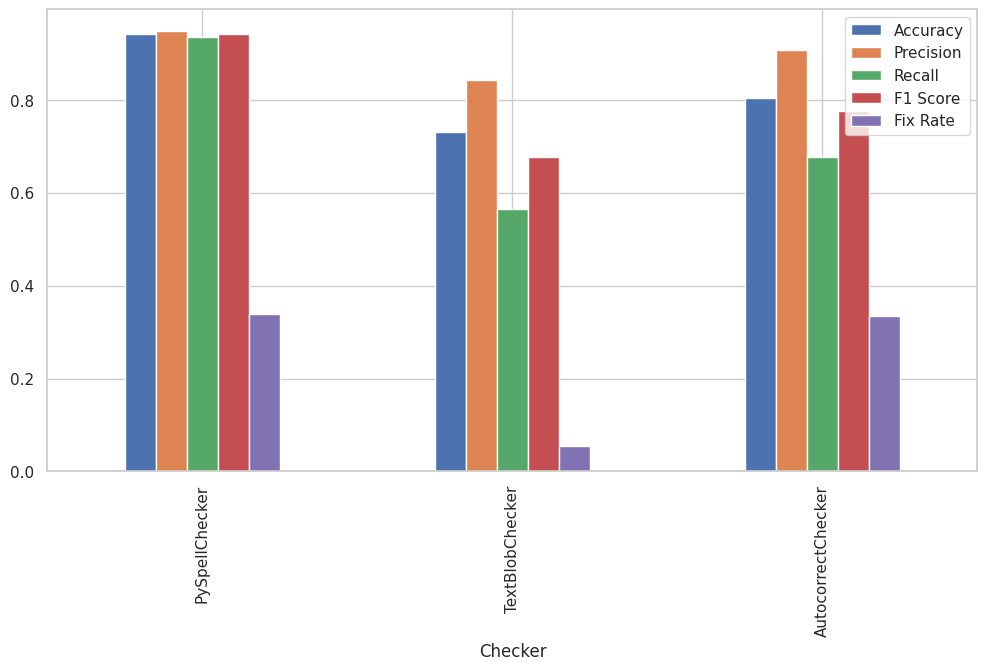

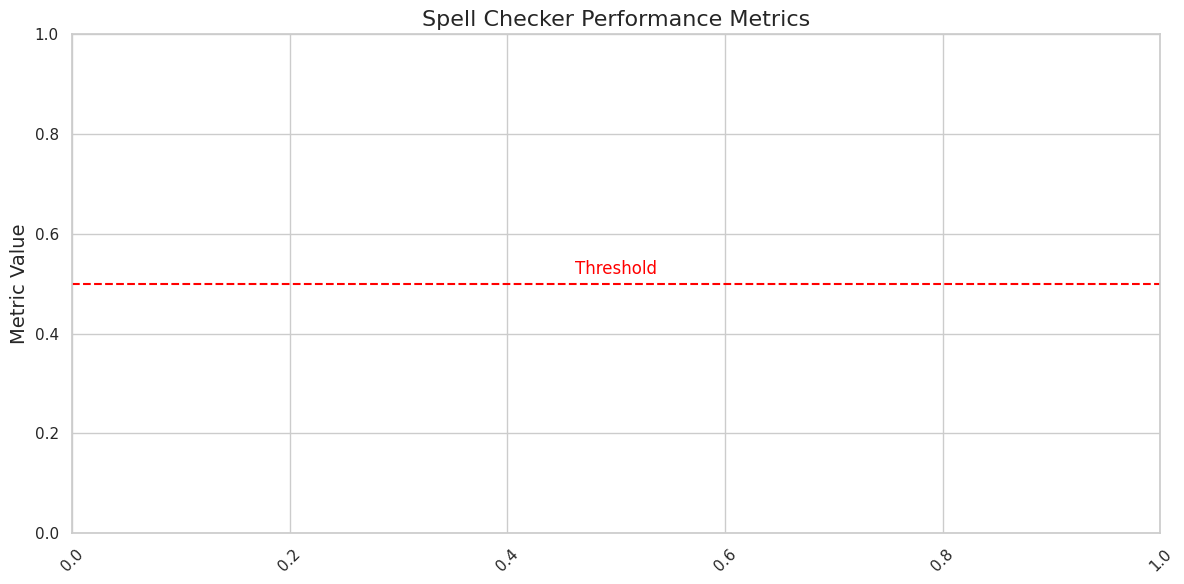

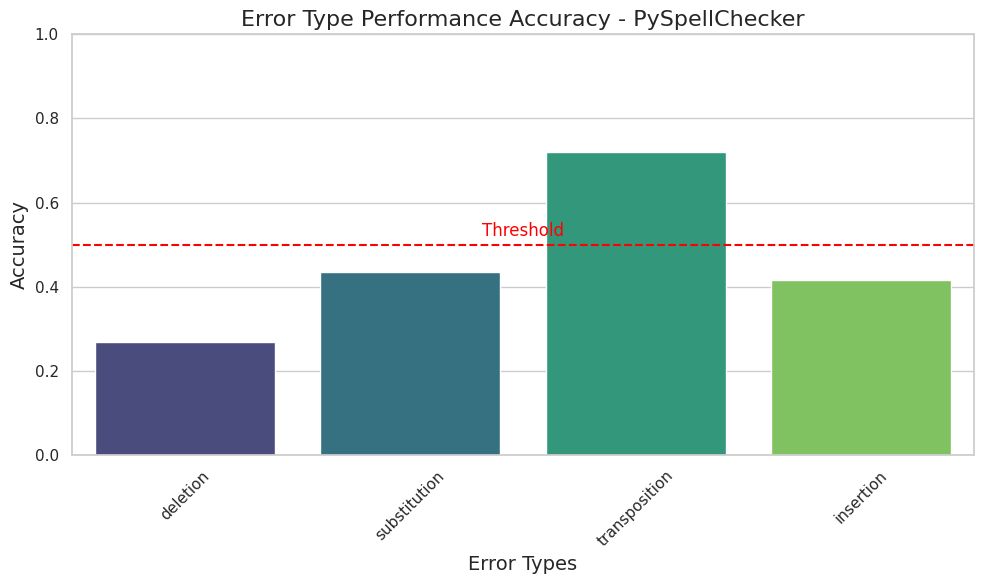

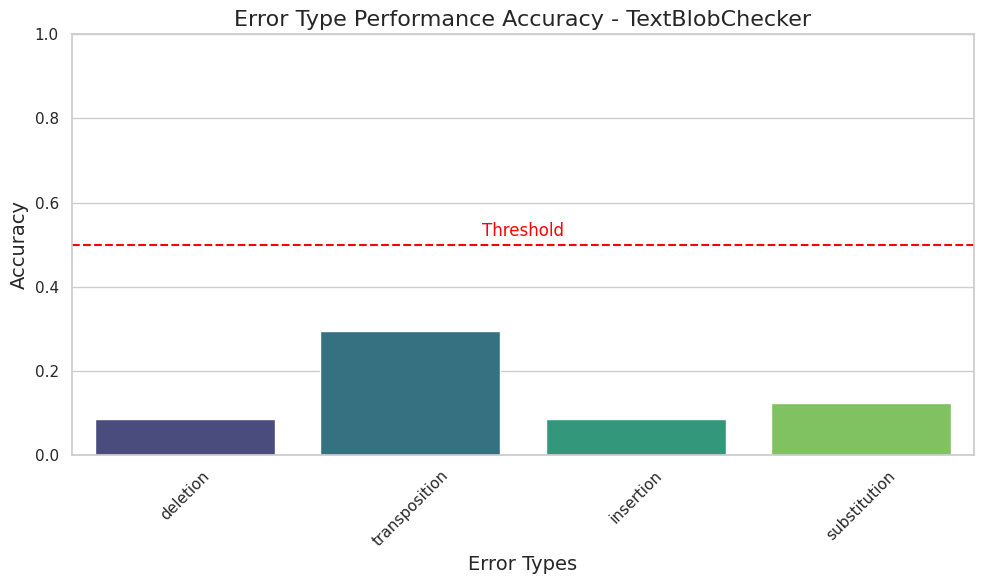

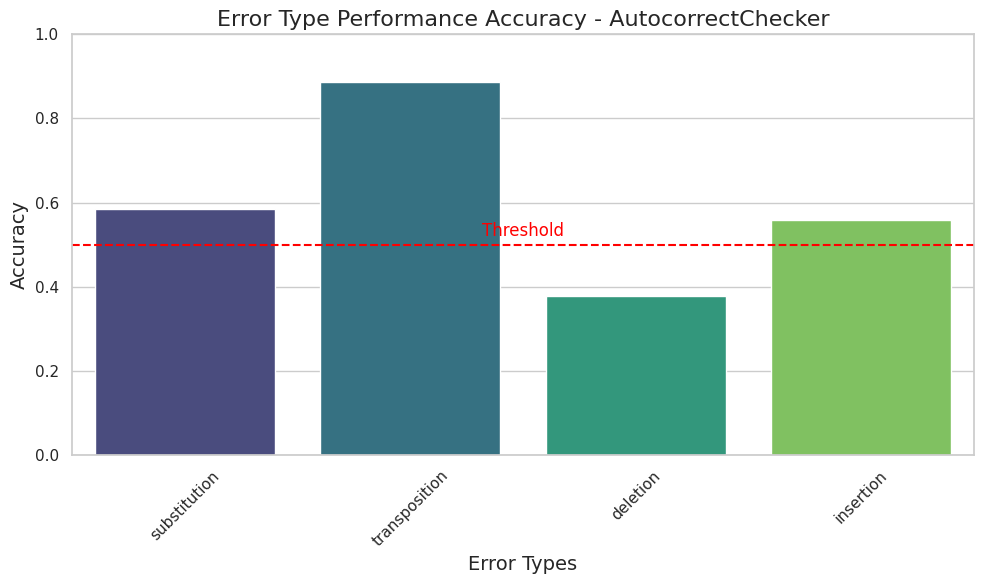

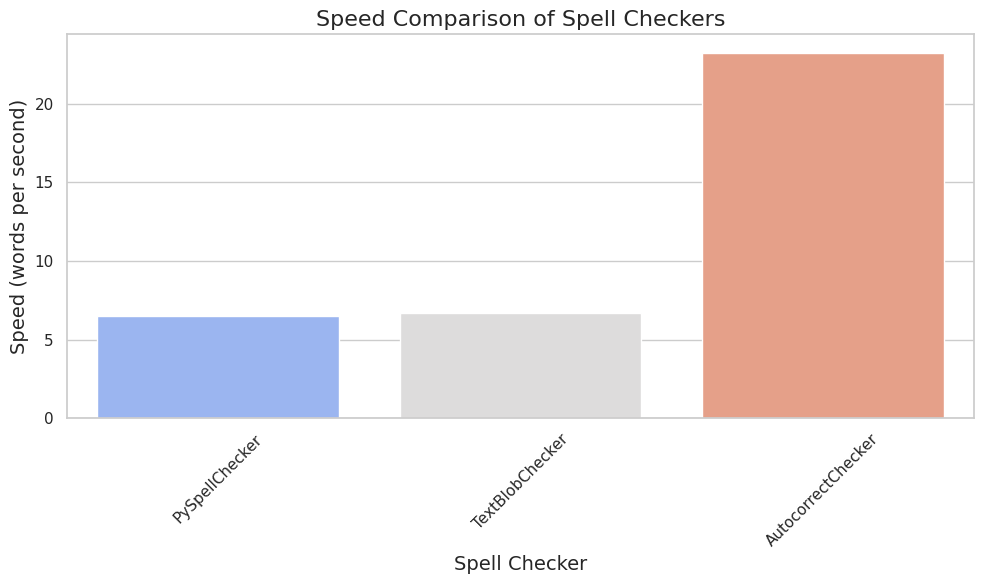

In [12]:
import pandas as pd
import numpy as np
from spellchecker import SpellChecker as PySpellCheckerLib
from textblob import TextBlob, Word
from autocorrect import Speller
import time
import matplotlib.pyplot as plt
import seaborn as sns

class SpellChecker:
    def __init__(self, name):
        self.__name = name

    def get_name(self):
        return self.__name

    def is_correct(word):
        return True

    def correct(word):
        return word

class PySpellChecker(SpellChecker):
    def __init__(self):
        super().__init__("PySpellChecker")
        self._spell_checker = PySpellCheckerLib()

    def is_correct(self, word):
        return word in self._spell_checker

    def correct(self, word):
        return self._spell_checker.correction(word)

class TextBlobChecker(SpellChecker):
    def __init__(self):
        super().__init__("TextBlobChecker")

    def is_correct(self, word):
        suggestions = Word(word).spellcheck()

        # Return true if the first suggestion has a confidence score of 1.0
        return suggestions and suggestions[0][1] == 1.0

    def correct(self, word):
        return TextBlob(word).correct()

class AutocorrectChecker(SpellChecker):
    def __init__(self):
        super().__init__("AutocorrectChecker")
        self._spell = Speller()

    def is_correct(self, word):
        corrected_word = self._spell(word)
        return corrected_word == word

    def correct(self, word):
        return self._spell(word)

def evaluate_spellchecker(incorrect_words, correct_words, spell_checker):
    total_incorrect = len(incorrect_words)
    total_correct = len(correct_words)
    total = total_incorrect + total_correct

    metrics = {
        'correct_fixes_count': 0,
        'wrong_fixes_count': 0,
        'false_positives': 0,
        'false_negatives': 0,
        'true_positives': 0,
        'true_negatives': 0,
    }

    error_type_performance = {}

    for index, row in incorrect_words.iterrows():
        correct_word = row['correct_word']
        misspelling = row['misspelling']
        error_type = row['error_type']

        if spell_checker.is_correct(misspelling):
            metrics['false_negatives'] += 1
            continue
        else:
            metrics['true_positives'] += 1

        suggestion = spell_checker.correct(misspelling)

        if suggestion == correct_word:
            metrics['correct_fixes_count'] += 1
            # Track performance by error type
            if error_type not in error_type_performance:
                error_type_performance[error_type] = {'correct': 0, 'total': 0}
            error_type_performance[error_type]['correct'] += 1
        else:
            metrics['wrong_fixes_count'] += 1

        # Increment total count for this error type
        if error_type not in error_type_performance:
            error_type_performance[error_type] = {'correct': 0, 'total': 0}
        error_type_performance[error_type]['total'] += 1

    metrics['fix_rate'] = metrics['correct_fixes_count'] / total_incorrect if total_incorrect > 0 else 0

    for word in correct_words:
        if spell_checker.is_correct(word):
            metrics['true_negatives'] += 1
        else:
            metrics['false_positives'] += 1

    # Calculate overall metrics
    accuracy = (metrics['true_positives'] + metrics['true_negatives']) / total if total > 0 else 0
    precision = (metrics['true_positives'] / (metrics['true_positives'] + metrics['false_positives'])) if (metrics['true_positives'] + metrics['false_positives']) > 0 else 0
    recall = (metrics['true_positives'] / (metrics['true_positives'] + metrics['false_negatives'])) if (metrics['true_positives'] + metrics['false_negatives']) > 0 else 0

    fx1score = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0

    # Calculate accuracy for each error type
    for error_type in error_type_performance:
        error_type_performance[error_type]['accuracy'] = (
            error_type_performance[error_type]['correct'] /
            error_type_performance[error_type]['total']
        )

    return accuracy, precision, recall, fx1score, metrics['fix_rate'], error_type_performance

# RUNNING CODE

# Load the datasets
CORRECT_WORDS_FILE = 'birkbeck_correct.txt'
INCORRECT_WORDS_FILE = 'birkbeck_misspell.csv'

incorrect_words = pd.read_csv(INCORRECT_WORDS_FILE)

with open(CORRECT_WORDS_FILE, 'r') as file:
    correct_words = [line.strip() for line in file]
correct_words_array = np.array(correct_words)

spell_checkers = [PySpellChecker(), TextBlobChecker(), AutocorrectChecker()]
results = []

for spell_checker in spell_checkers:
    start_time = time.time()

    accuracy, precision, recall, fx1score, fix_rate, error_type_performance = evaluate_spellchecker(incorrect_words, correct_words_array, spell_checker)

    # Print results of checker's measurements
    print("==========================")
    print(f"Checker: {spell_checker.get_name()}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {fx1score:.4f}")
    print(f"Fix Rate: {fix_rate:.4f}")
    print("Error Type Performance:", error_type_performance)

    words_processed = len(incorrect_words) + len(correct_words)
    spent_time = time.time() - start_time
    words_per_second = words_processed / spent_time if spent_time > 0 else 0

    print(f"Words per second: {words_per_second:.2f}")
    print(f"Time spent: {spent_time/60:.2f} minutes")

    # Results for visualization
    results.append({
        "Checker": spell_checker.get_name(),
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": fx1score,
        "Fix Rate": fix_rate,
        "Speed": words_per_second,
        "Error Type Performance": error_type_performance,
    })

# Visualization of performance metrics using Bar charts
results_df = pd.DataFrame(results)

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Fix Rate']
results_df.set_index('Checker')[metrics_to_plot].plot(kind='bar', figsize=(12,6))

plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")
plt.title('Spell Checker Performance Metrics', fontsize=16)
plt.ylabel('Metric Value', fontsize=14)
plt.ylim(0, 1)
plt.axhline(0.5, color='red', linestyle='--')
plt.text(0.5, 0.52, 'Threshold', color='red', ha='center')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualization of Error Type Performance using Bar chart
for result in results:
    error_types = result["Error Type Performance"]

    labels = list(error_types.keys())

    accuracies = [data["accuracy"] for data in error_types.values()]

    plt.figure(figsize=(10,6))

    sns.barplot(x=labels, y=accuracies, palette='viridis')

    plt.title(f'Error Type Performance Accuracy - {result["Checker"]}', fontsize=16)
    plt.xlabel('Error Types', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)

    plt.ylim(0, 1)

    plt.axhline(0.5, color='red', linestyle='--')
    plt.text(len(labels)/2 - 0.5, 0.52, 'Threshold', color='red', ha='center')

    plt.xticks(rotation=45)

    plt.tight_layout()

    plt.show()

# Visualization of Speed Comparison using Bar chart
speed_data = {
   "Checker": [result["Checker"] for result in results],
   "Speed (words/sec)": [result["Speed"] for result in results]
}

speed_df = pd.DataFrame(speed_data)

plt.figure(figsize=(10,6))
sns.barplot(x="Checker", y="Speed (words/sec)", data=speed_df, palette='coolwarm')

plt.title('Speed Comparison of Spell Checkers', fontsize=16)
plt.xlabel('Spell Checker', fontsize=14)
plt.ylabel('Speed (words per second)', fontsize=14)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

